In [2]:
import os, sys

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii as at
from astropy.table import join,vstack,Table
from scipy import stats

In [3]:
# Read in and merge the outputs from k2spin

base_dir = os.path.expanduser("~/data/tess/ic2391/tables/")
file_list = at.read(os.path.join(base_dir,"IC2391_2021-05-19.lst"))

In [4]:
all_arr = []
for filename in file_list["Filename"]:
    all_arr.append(at.read(os.path.join(base_dir,filename)))

In [5]:
results = vstack(all_arr)

In [6]:
results["target_name","provenance_name","sequence_number","sig_periods","num_sig_peaks"].show_in_notebook()

idx,target_name,provenance_name,sequence_number,sig_periods,num_sig_peaks
0,44999952,CDIPS,8,0.3078,2
1,44999952,CDIPS,9,0.3079,1
2,44999952,CDIPS,10,0.3075,1
3,45049176,PATHOS,8,32.6843,3
4,45049176,PATHOS,9,3.309,3
5,45050711,CDIPS,8,0.7763,2
6,45050711,CDIPS,9,0.7747,0
7,45050711,CDIPS,10,0.7755,1
8,45050711,PATHOS,8,19.9067,1
9,45050711,PATHOS,9,25.4777,4


In [7]:
u_tic = np.unique(results["target_name"])

In [8]:
u_tic.dtype

dtype('int64')

In [9]:
N = len(u_tic)
dtype = [('TIC', 'int64'), ('NProt', 'i4'), ('Nclean', 'i4'), ('Prot', 'f8'), ('Prot_avg', 'f8'), ('Prot_std', 'f8')]
summary = Table(data=np.zeros(N, dtype=dtype))

In [10]:
clean_threshold = 0

In [11]:
for i, tic in enumerate(u_tic):
    loc = results["target_name"]==tic
    summary["TIC"][i] = tic
    summary["NProt"][i] = len(np.where(loc)[0])
    clean = np.where(loc & (results["num_sig_peaks"]==clean_threshold) & (results["sig_periods"]>0))[0]
    summary["Nclean"][i] = len(clean)
    if len(clean)>0:
        clean_short = np.where(loc & (results["num_sig_peaks"]==clean_threshold) & (results["sig_periods"]<=12))[0]
        
        if len(clean_short)>0:
            summary["Prot"][i] = results["sig_periods"][clean_short][0]
            summary["Prot_avg"][i] = np.mean(results["sig_periods"][clean_short])
            summary["Prot_std"][i] = np.std(results["sig_periods"][clean_short])
        else:
            summary["Prot"][i] = results["sig_periods"][clean][0]
            summary["Prot_avg"][i] = np.mean(results["sig_periods"][clean])
            summary["Prot_std"][i] = np.std(results["sig_periods"][clean])
            
    else:
        summary["Prot"][i] = -99

In [12]:
summary.show_in_notebook()

idx,TIC,NProt,Nclean,Prot,Prot_avg,Prot_std
0,44999952,18,2,0.3078,0.30765,0.00015000000000001124
1,45049176,8,0,-99.0,0.0,0.0
2,45050711,30,4,0.7747,0.77415,0.0007664854858378188
3,45184491,18,8,0.6919,-1999.24609,3999.8769550000347
4,45402598,30,3,0.6543,0.6544666666666666,0.00016996731711974077
5,45402925,20,5,2.8751,2.88068,0.012274265762154514
6,45404408,30,9,0.7585,-1110.3266888888888,3142.6205870193326
7,45407296,18,0,-99.0,0.0,0.0
8,45781130,20,1,2.0864,2.0864,0.0
9,45786218,20,6,1.0977,-2498.9280750000003,4330.168544840558


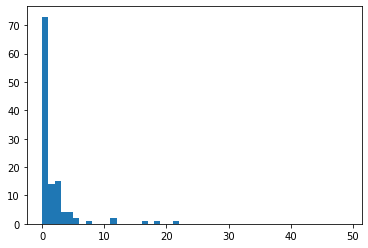

In [13]:
_ = plt.hist(summary["Prot"],bins=np.arange(0,50))

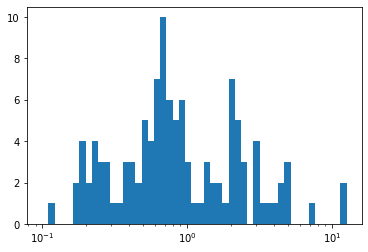

In [14]:
_ = plt.hist(summary["Prot"],bins=np.logspace(-1,1.1))
plt.xscale("log")

# Crossmatch back to Gaia data

In [15]:
gaia = at.read("IC2391_crossmatch_xmatch_TIC.csv")

In [16]:
summary_gaia = join(summary,gaia,keys=["TIC"])

In [17]:
len(summary_gaia)

267

# Period-color plots

In [18]:
bp_rp = summary_gaia["GAIAEDR3_BP"] - summary_gaia["GAIAEDR3_RP"]

In [19]:
std_avg = summary_gaia["Prot_std"]/summary_gaia["Prot_avg"]
clean = (summary_gaia["Nclean"]==1) #& (std_avg<=0.1)

/Users/stephanie/anaconda3/envs/lightkurve/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


42


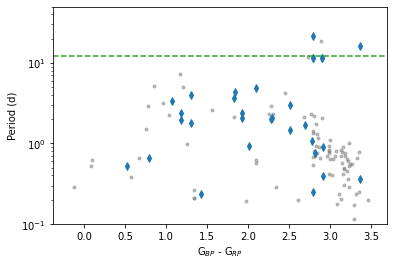

In [20]:
plt.plot(bp_rp,summary_gaia["Prot"],'.',color="grey",alpha=0.5)
plt.plot(bp_rp[clean],summary_gaia["Prot"][clean],'d',ms=5)
print(len(np.where(clean)[0]))

plt.ylim(0.1,50)
plt.yscale("log")

plt.xlabel(r"G$_{BP}$ - G$_{RP}$")
plt.ylabel("Period (d)")

ax = plt.gca()
ax.axhline(12,linestyle="--",color="C2")

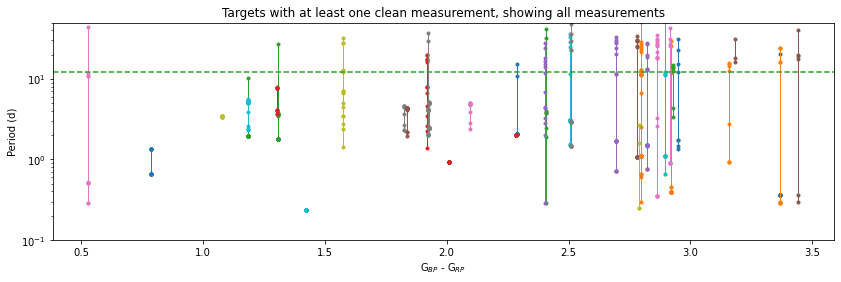

In [21]:
plt.figure(figsize=(14,4))
for i in np.where(clean)[0]:
    loc = np.where((results["target_name"]==summary_gaia["TIC"][i]) & (results["sig_periods"]>0))[0]
    plt.plot(np.ones(len(loc))*bp_rp[i],results["sig_periods"][loc],marker=".",linewidth=1)

plt.ylim(0.1,50)
plt.yscale("log")

plt.xlabel(r"G$_{BP}$ - G$_{RP}$")
plt.ylabel("Period (d)")
plt.title("Targets with at least one clean measurement, showing all measurements")

ax = plt.gca()
ax.axhline(12,linestyle="--",color="C2")

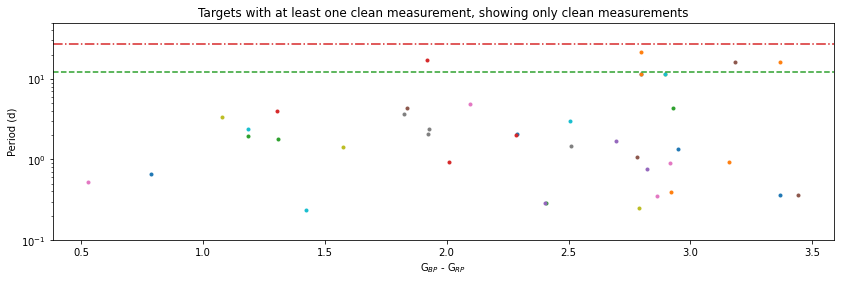

In [22]:
plt.figure(figsize=(14,4))
for i in np.where(clean)[0]:
    loc = np.where((results["target_name"]==summary_gaia["TIC"][i]) & (results["sig_periods"]>0) & (results["num_sig_peaks"]<=clean_threshold))[0]
    plt.plot(np.ones(len(loc))*bp_rp[i],results["sig_periods"][loc],marker=".",linewidth=1)

plt.ylim(0.1,50)
plt.yscale("log")

plt.xlabel(r"G$_{BP}$ - G$_{RP}$")
plt.ylabel("Period (d)")
plt.title("Targets with at least one clean measurement, showing only clean measurements")

ax = plt.gca()
ax.axhline(12,linestyle="--",color="C2")
ax.axhline(27,linestyle="-.",color="C3")

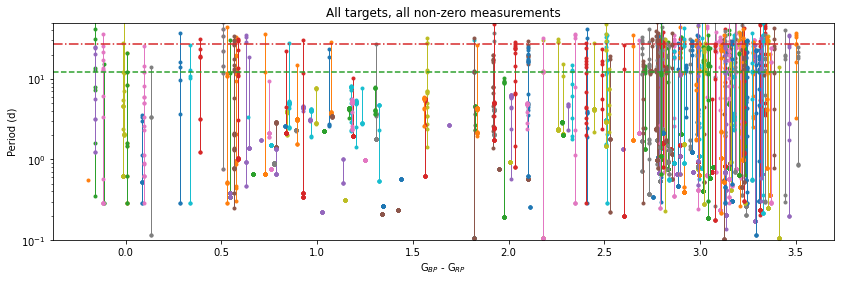

In [23]:
plt.figure(figsize=(14,4))
plt.plot(bp_rp,summary_gaia["Prot"],'.',color="grey",alpha=0.5)
for i in np.arange(len(summary_gaia)):
    loc = np.where((results["target_name"]==summary_gaia["TIC"][i]) & (results["sig_periods"]>0))[0]
    plt.plot(np.ones(len(loc))*bp_rp[i],results["sig_periods"][loc],marker=".",linewidth=1)

plt.ylim(0.1,50)
plt.yscale("log")

plt.xlabel(r"G$_{BP}$ - G$_{RP}$")
plt.ylabel("Period (d)")
plt.title("All targets, all non-zero measurements")

ax = plt.gca()
ax.axhline(12,linestyle="--",color="C2")
ax.axhline(27,linestyle="-.",color="C3")

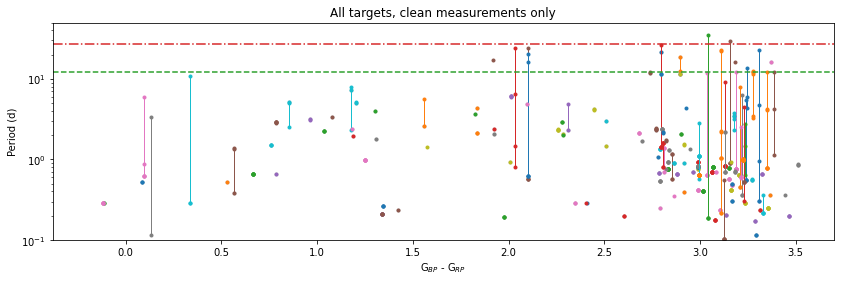

In [24]:
plt.figure(figsize=(14,4))
plt.plot(bp_rp,summary_gaia["Prot"],'.',color="grey",alpha=0.5)
for i in np.arange(len(summary_gaia)):
    loc = np.where((results["target_name"]==summary_gaia["TIC"][i]) & (results["sig_periods"]>0) & (results["num_sig_peaks"]<=clean_threshold))[0]
    plt.plot(np.ones(len(loc))*bp_rp[i],results["sig_periods"][loc],marker=".",linewidth=1)

plt.ylim(0.1,50)
plt.yscale("log")

plt.xlabel(r"G$_{BP}$ - G$_{RP}$")
plt.ylabel("Period (d)")
plt.title("All targets, clean measurements only")

ax = plt.gca()
ax.axhline(12,linestyle="--",color="C2")
ax.axhline(27,linestyle="-.",color="C3")

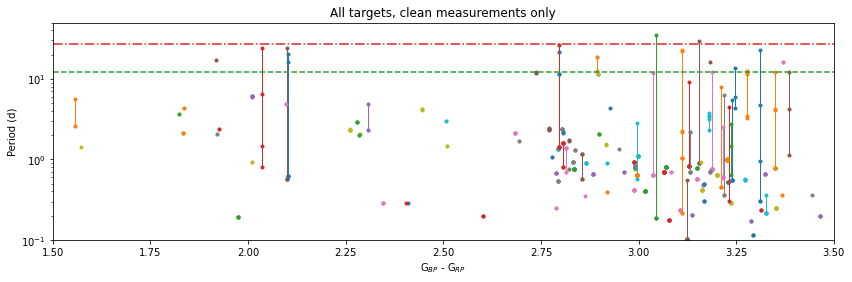

In [25]:
plt.figure(figsize=(14,4))
plt.plot(bp_rp,summary_gaia["Prot"],'.',color="grey",alpha=0.5)
for i in np.arange(len(summary_gaia)):
    loc = np.where((results["target_name"]==summary_gaia["TIC"][i]) & (results["sig_periods"]>0) & (results["num_sig_peaks"]<=clean_threshold))[0]
    plt.plot(np.ones(len(loc))*bp_rp[i],results["sig_periods"][loc],marker=".",linewidth=1)

plt.ylim(0.1,50)
plt.yscale("log")
plt.xlim(1.5,3.5)

plt.xlabel(r"G$_{BP}$ - G$_{RP}$")
plt.ylabel("Period (d)")
plt.title("All targets, clean measurements only")

ax = plt.gca()
ax.axhline(12,linestyle="--",color="C2")
ax.axhline(27,linestyle="-.",color="C3")

# Patten & Simon comparison

In [26]:
ps = at.read("IC2391_rotation_patten1996_simbad.csv")
tics = np.zeros(len(ps),'int64')
for i in np.where(ps["TICID"].mask==False)[0]:
    tics[i] = ps["TICID"][i].replace("TIC ","")
print(tics)

[ 93549309  93551206  93833881  93832681  93832296  93912428  93912319
  93911997         0         0  94185535  94184640  94184909 144752281
 144759493 144993360]


In [27]:
ps["TIC"] = tics

In [28]:
# Something is wrong with this crossmatching
# Or not, it's just because there weren't any clean results for those other stars
ps_tess = join(ps,summary_gaia,keys=["TIC"])

In [29]:
ps_tess

Name,Spectral,V-I,Period,logNr,TICID,GaiaDR2_1,SimbadName,TIC,NProt,Nclean,Prot,Prot_avg,Prot_std,angDist,TMASS_ID,UKIDSS_ID,GAIAEDR3_ID,GAIADR2_G,GAIADR2_BP,GAIADR2_RP,GAIAEDR3_G,GAIAEDR3_BP,GAIAEDR3_RP,GAIADR2_PARALLAX,GAIADR2_PARALLAX_ERROR,GAIADR2_RUWE,GAIAEDR3_RA,GAIAEDR3_DEC,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMDEC,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_RUWE,GAIAEDR3_G_CORRECTED,GAIAEDR3_PARALLAX_CORRECTED,HDBscan_MemProb,HDBscan_Cluster,HDBscan_Stability,MemBool,angDist_GES,target,filter,cluster,S/N,Teff,logg,gamma,Ks,RV_1,e_RV,logL,ra_epoch2000_GES,dec_epoch2000_GES,PLX,e_PLX,VRA,e_VRA,VDec,e_VDec,RV_2,SRV,Gflag,prob_p,p_filter,angDist_Cantat-Gaudin,RA_ICRS,DE_ICRS,GaiaDR2_2,Plx,pmRA*,pmDE,RV,o_Gmag,Gmag,BP-RP,proba,Cluster,Teff50,ra_epoch2000_Cantat-Gaudin,dec_epoch2000_Cantat-Gaudin,RAdeg,DEdeg,HIP,TYC,UCAC4,2MASS,objID,WISEA,GAIA,APASS,KIC,S/G,Ref,r_Pos,pmRA,e_pmRA,pmDE_1,e_pmDE,r_pm,Plx_1,e_Plx,Vmag,e_Vmag,Gmag_1,e_Gmag,Tmag,e_Tmag,f_Tmag,Flag,Teff_1,s_Teff,logg_1,s_logg,[M/H],e_[M/H],Rad,s_Rad,Mass,s_Mass,Dist,s_Dist,E(B-V),s_E(B-V),e_Dist,E_Dist,RAOdeg,DEOdeg
str7,str5,float64,float64,float64,str13,str28,str18,int64,int32,int32,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,str6,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,str7,float64,float64,float64,float64,float64,int64,str12,str10,str16,int64,str19,int64,int64,int64,str4,str7,str7,float64,float64,float64,float64,str6,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
VXR 12,K0,0.91,3.86,-0.72,TIC 93549309,Gaia DR2 5318545521198976000,VXR PSPC 12,93549309,9,0,-99.0,0.0,0.0,0.546009,1998032529994886582,0,5318545521198976000,--,--,--,11.673631,12.125574,11.055223,--,--,--,129.97086023758,-52.96568437976,6.6211,0.0103,-24.222,23.987,0.012,0.011,0.795,11.673631,6.641477108222062,0.9939476886437819,0.0,0.24671625890317983,1.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.528233,129.97086582221,-52.96568777242,5318545521198976000,6.55993899971808,-24.3500677917294,23.8963317855437,16.8548451194966,273,11.658394,1.0710506,1.0,IC_2391,5421.3535,129.97103898086,-52.96579098717,129.97103989186,-52.96579065914,--,--,186-020290,08395305-5257569,--,J083953.02-525756.6,5318545521198976000,24741714,--,STAR,tmgaia2,tmgaia2,-24.35,0.042,23.896,0.043,gaia2,6.5599,0.0238,11.83,0.046,11.6584,0.00254,11.104,0.007,rered,gaia2,5312.0,126.8,4.5869,0.0818,--,--,0.804,0.045,0.91,0.116,151.773,0.552,0.0695,0.0097,0.55,0.554,129.97086582222,-52.96568777242
VXR 14,G0,0.69,1.32,-0.74,TIC 93551206,Gaia DR2 5318096125872352768,VXR PSPC 14,93551206,13,1,0.6672,0.6672,0.0,0.51056,1962021325161886069,0,5318096125872352768,--,--,--,10.308978,10.61807,9.831229,--,--,--,130.02579185803,-53.63514751083,6.4494,0.0167,-23.412,21.541,0.022,0.019,1.352,10.308978,6.459716919217498,0.3506306475269543,0.0,0.24671625890317983,1.0,0.16893,08400624-5338069,580.0,IC2391,38.75,5810,4.35,-999.0,8.9,16.23,0.59,0.13,130.02596735192,-53.6352432466,6.29,0.02,-17.13,0.04,15.5,0.03,16.23,0.59,1,0.9993,0.9993,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,130.02596917931,-53.63524269249,--,8569-02827-1,182-020135,08400624-5338069,--,J084006.21-533806.6,5318096125872352768,26280928,--,STAR,tmgaia2,tmgaia2,-23.664,0.053,21.4,0.043,gaia2,6.2934,0.0241,10.475,0.007,10.3034,0.001122,9.888,0.006,rered,spect,5808.0,131.4,4.2502,0.0798,-0.05,0.14,1.266,0.066,1.04,0.129,158.173,0.608

Text(0.5, 1.0, 'Clean TESS periods')

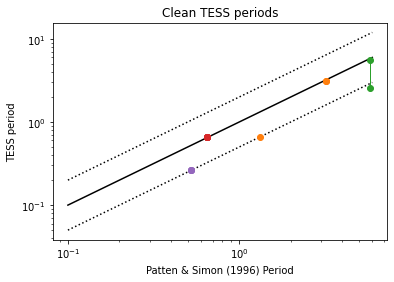

In [55]:
x = np.linspace(0.1,6,5)
plt.plot(x,x,"k-")
plt.plot(x,x/2,"k:",)
plt.plot(x,2*x,"k:")

plt.xscale("log")
plt.yscale("log")

for i in np.arange(len(ps_tess)):
    loc = np.where((results["target_name"]==ps_tess["TIC"][i]) & (results["sig_periods"]>0) & (results["num_sig_peaks"]<=clean_threshold))[0]
    plt.plot(np.ones(len(loc))*ps_tess["Period"][i],results["sig_periods"][loc],marker="o",linewidth=1)

# plt.plot(ps_tess["Prot"][good_match],ps_tess["Period"][good_match],'o')

plt.ylabel("TESS period")
plt.xlabel("Patten & Simon (1996) Period")
plt.title("Clean TESS periods")

Text(0.5, 1.0, 'All TESS periods')

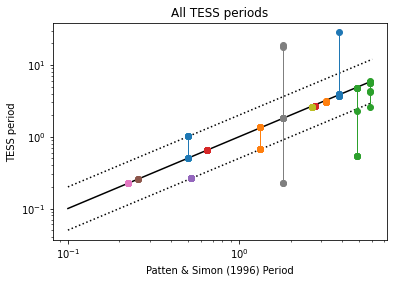

In [54]:
x = np.linspace(0.1,6,5)
plt.plot(x,x,"k-")
plt.plot(x,x/2,"k:",)
plt.plot(x,2*x,"k:")

plt.xscale("log")
plt.yscale("log")

for i in np.arange(len(ps_tess)):
    loc = np.where((results["target_name"]==ps_tess["TIC"][i]) & (results["sig_periods"]>0))[0]
    plt.plot(np.ones(len(loc))*ps_tess["Period"][i],results["sig_periods"][loc],marker="o",linewidth=1)

# plt.plot(ps_tess["Prot"][good_match],ps_tess["Period"][good_match],'o')

plt.ylabel("TESS period")
plt.xlabel("Patten & Simon (1996) Period")
plt.title("All TESS periods")

Text(0.5, 1.0, 'Clean TESS periods')

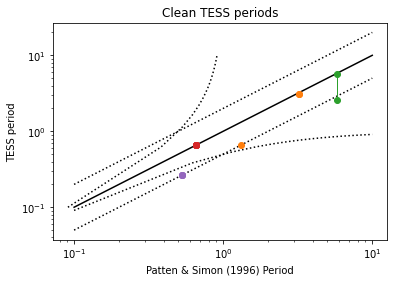

In [56]:
x = np.linspace(0.1,10,20)
plt.plot(x,x,"k-")
plt.plot(x,x/2,"k:",)
plt.plot(x,2*x,"k:")

# I'm not 100% sure I'm doing this right, 
# but I can't find my old code on this computer
d = 1
plt.plot(x,1/(1/x+1/d),"k:")
plt.plot(1/(1/x+1/d),x,"k:")

plt.xscale("log")
plt.yscale("log")

for i in np.arange(len(ps_tess)):
    loc = np.where((results["target_name"]==ps_tess["TIC"][i]) & (results["sig_periods"]>0) & (results["num_sig_peaks"]<=clean_threshold))[0]
    plt.plot(np.ones(len(loc))*ps_tess["Period"][i],results["sig_periods"][loc],marker="o",linewidth=1)

# plt.plot(ps_tess["Prot"][good_match],ps_tess["Period"][good_match],'o')

plt.ylabel("TESS period")
plt.xlabel("Patten & Simon (1996) Period")
plt.title("Clean TESS periods")

In [32]:

for i in np.arange(len(ps_tess)):
    loc = np.where((results["target_name"]==ps_tess["TIC"][i]) & (results["sig_periods"]>0))[0]
    print("\n",ps_tess["TIC"][i],ps_tess["Period"][i],"d")
    print(results["sig_periods","num_sig_peaks","harm_types","sequence_number","flux_cols"][loc])



 93549309 3.86 d
sig_periods num_sig_peaks harm_types sequence_number  flux_cols  
----------- ------------- ---------- --------------- ------------
     3.6731             5          -               8 psf_flux_cor
     3.9021             5          -               9 psf_flux_cor
      3.897             3       half               9     sap_flux
     3.6508             5          -               8 ap1_flux_cor
     3.6686             6          -               8 ap2_flux_cor
     3.6641             6          -               8 ap3_flux_cor
     3.9021             5          -               9 ap1_flux_cor
     3.9021             4          -               9 ap2_flux_cor
    28.3642             5          -               9 ap3_flux_cor

 93551206 1.32 d
sig_periods num_sig_peaks harm_types sequence_number flux_cols
----------- ------------- ---------- --------------- ---------
     1.3582             3 half-maybe               8      TFA1
     0.6672             0        dbl             

In [33]:
results.dtype

dtype([('target_name', '<i8'), ('provenance_name', '<U6'), ('sequence_number', '<i8'), ('obs_id', '<U77'), ('productFilename', '<U82'), ('author', '<U6'), ('fund_periods', '<f8'), ('fund_powers', '<f8'), ('sig_periods', '<f8'), ('sig_powers', '<f8'), ('sec_periods', '<f8'), ('sec_powers', '<f8'), ('thresholds', '<f8'), ('tics', '<i8'), ('num_sig_peaks', '<i8'), ('harm_types', '<U10'), ('flux_cols', '<U12')])

# More filtering

In [34]:
# Read in and merge the outputs from k2spin - all peaks from every periodogram

file_list = at.read(os.path.join(base_dir,"IC2391_2021-05-19_allpeaks.lst"))
all_arr = []
for filename in file_list["Filename"]:
    all_arr.append(at.read(os.path.join(base_dir,filename)))
all_peaks = vstack(all_arr)

In [35]:
all_peaks.rename_column("lc_type","provenance_name")
all_peaks.rename_column("sector","sequence_number")
all_peaks.rename_column("TIC","target_name")

In [36]:
all_peaks

target_name,provenance_name,sequence_number,flux_col,period,power,threshold
int64,str6,int64,str12,float64,float64,float64
44999952,CDIPS,8,TFA1,0.7384,0.0416,0.0356
44999952,CDIPS,8,TFA1,0.313,0.059,0.0356
44999952,CDIPS,8,TFA1,0.3078,0.1991,0.0356
44999952,CDIPS,8,TFA2,0.7405,0.0297,0.0274
44999952,CDIPS,8,TFA2,0.3076,0.1069,0.0274
44999952,CDIPS,8,TFA2,0.3025,0.0333,0.0274
44999952,CDIPS,8,TFA3,0.3078,0.0417,0.0289
44999952,CDIPS,8,PCA1,0.7389,0.0585,0.0315
44999952,CDIPS,8,PCA1,0.3077,0.2501,0.0315


In [37]:
# OK, so what's the best way to filter this? Options:
# Old "clean" flag, where there are no other peaks higher than 60% of the top peak
# Looking for other peaks *lower* than the long systematic peak, but still significant

In [38]:
results2 = results.copy()
results2["clean60"] = np.zeros(len(results2),int)
results2["half"] = np.zeros(len(results2),int)
results2["dbl"] = np.zeros(len(results2),int)
# results2["period_long"] = np.ones(len(results2),float)*-99
# results2["power_long"] = np.ones(len(results2),float)*-99
results2["period_short"] = np.ones(len(results2),float)*-99
results2["power_short"] = np.ones(len(results2),float)*-99

In [39]:
for i,row in enumerate(results2):
    
    # Find all the all_peaks locations, by target_name, provenance_name, and sequence_number
    loc = ((all_peaks["target_name"]==row["target_name"]) &
           (all_peaks["provenance_name"]==row["provenance_name"]) &
           (all_peaks["flux_col"]==row["flux_cols"]) &
           (all_peaks["sequence_number"]==row["sequence_number"]))
    loc = np.where(loc)[0]
    
#     print(row["target_name","provenance_name","sequence_number","flux_cols"])
    
    if len(loc)==0:
#         print("no peaks found")
#         print(row["target_name","provenance_name","sequence_number","flux_cols"])
        continue
    
    sub_tab = all_peaks[loc]
#     print(sub_tab)
    
    # Are all the other peaks <60% the height of the main peak?
    main = np.argmax(sub_tab["power"])
    max_power = sub_tab["power"][main]
    max_per = sub_tab["period"][main]
    
    contaminants = np.where(sub_tab["power"]>=(0.6*max_power))[0]
    # one match is just going to be the primary peak itself
    ncontam = len(contaminants) -1
    
    if ncontam>0:
        results2["clean60"][i] = ncontam
#         print("not clean",ncontam)
    
        # Are there potentially half or double harmonics?
        tolerance = 0.05 
        contam_diff = abs(max_per-sub_tab["period"][contaminants])/max_per
        
        if np.any(abs(contam_diff-0.5)<tolerance):
            results2["half"][i] = 1
#             print("half")
#             print(contam_diff)

        if np.any(abs(contam_diff-2)<tolerance):
            results2["dbl"][i] = 1
#             print("double")
#             print(contam_diff)
    else:
        print("clean")
    
    # If the highest peak is >13 days, are there other significant periods?
    if max_per>13:
        short = sub_tab["period"]<=13
        if np.any(short):
#             print("found shorter periods")
            sub_tab2 = sub_tab[short]
            short_max = np.argmax(sub_tab2["power"])
#             row["period_long"] = row["sig_periods"]
#             row["power_long"] = row["sig_powers"]
#             row["sig_periods"] = sub_tab2["period"][short_max]
#             row["sig_powers"] = sub_tab2["power"][short_max]
            row["period_short"] = sub_tab2["period"][short_max]
            row["power_short"] = sub_tab2["power"][short_max]
        else:
            continue

clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clea

clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clean
clea

In [40]:
results2["target_name","provenance_name","sequence_number","flux_cols","sig_periods","clean60","half","dbl"].show_in_notebook()

idx,target_name,provenance_name,sequence_number,flux_cols,sig_periods,clean60,half,dbl
0,44999952,CDIPS,8,TFA1,0.3078,0,0,0
1,44999952,CDIPS,9,TFA1,0.3079,0,0,0
2,44999952,CDIPS,10,TFA1,0.3075,0,0,0
3,45049176,PATHOS,8,psf_flux_cor,32.6843,0,0,0
4,45049176,PATHOS,9,psf_flux_cor,3.309,0,0,0
5,45050711,CDIPS,8,TFA1,0.7763,0,0,0
6,45050711,CDIPS,9,TFA1,0.7747,0,0,0
7,45050711,CDIPS,10,TFA1,0.7755,0,0,0
8,45050711,PATHOS,8,psf_flux_cor,19.9067,2,1,0
9,45050711,PATHOS,9,psf_flux_cor,25.4777,0,0,0


In [41]:
# for i, tic in enumerate(u_tic):
#     loc = all_peaks["target_name"]==tic
#     mode_prot = stats.mode(all_peaks["period"][loc])
#     print(tic,len(np.where(loc)[0]),mode_prot)
#     if i>10:
#         break

In [42]:
N = len(u_tic)
dtype = [('TIC', 'int64'), ('NProt', 'i4'), ('Nclean', 'i4'), ('Prot', 'f8'), ('Prot_avg', 'f8'), ('Prot_std', 'f8'),
         ('provenance_name','a6'),('sequence_number','i4'),('flux_cols','a12')]
summary2 = Table(data=np.zeros(N, dtype=dtype))

In [43]:
for i, tic in enumerate(u_tic):
    loc = results2["target_name"]==tic
    summary2["TIC"][i] = tic
    summary2["NProt"][i] = len(np.where(loc)[0])
    clean = np.where(loc & (results2["clean60"]==0) & (results2["sig_periods"]>0))[0]
    summary2["Nclean"][i] = len(clean)
    
    if len(clean)>0:
        clean_short = np.where(loc & (results2["clean60"]==0) & 
                               (results2["sig_periods"]>0) & (results2["sig_periods"]<=13))[0]
        
        if len(clean_short)==1:
            summary2["Prot"][i] = results2["sig_periods"][clean_short][0]
            summary2["Prot_avg"][i] = np.mean(results2["sig_periods"][clean_short])
            summary2["Prot_std"][i] = np.std(results2["sig_periods"][clean_short])
            summary2["provenance_name"][i] = results2["provenance_name"][clean_short][0]
            summary2["sequence_number"][i] = results2["sequence_number"][clean_short][0]
            summary2["flux_cols"][i] = results2["flux_cols"][clean_short][0]
        elif len(clean_short)>1:
            sub_tab = results2[clean_short]
            best = np.argmax(sub_tab["sig_powers"])
            summary2["Prot"][i] = sub_tab["sig_periods"][best]
            summary2["Prot_avg"][i] = np.mean(sub_tab["sig_periods"])
            summary2["Prot_std"][i] = np.std(sub_tab["sig_periods"])            
        else:
            summary2["Prot"][i] = results2["sig_periods"][clean][0]
            summary2["Prot_avg"][i] = np.mean(results2["sig_periods"][clean])
            summary2["Prot_std"][i] = np.std(results2["sig_periods"][clean])
            
    else:
        summary2["Prot"][i] = -99
        

In [44]:
summary2.show_in_notebook()

idx,TIC,NProt,Nclean,Prot,Prot_avg,Prot_std,provenance_name,sequence_number,flux_cols
0,44999952,18,16,0.3077,0.3076375,0.00016909686573086198,,0,
1,45049176,8,6,3.309,3.309,0.0,PATHOS,9,psf_flux_cor
2,45050711,30,22,4.8307,1.8298944444444447,2.6993495785450534,,0,
3,45184491,18,13,0.6919,0.6921769230769231,0.000892838038679801,,0,
4,45402598,30,25,0.6548,0.6546105263157895,0.0002531792309643447,,0,
5,45402925,20,15,2.8751,2.3003666666666667,0.7074922705506321,,0,
6,45404408,30,26,0.757,1.3912388888888887,2.6135302876758026,,0,
7,45407296,18,0,-99.0,0.0,0.0,,0,
8,45781130,20,20,2.0763,2.5409631578947374,1.9582410811237094,,0,
9,45786218,20,12,1.0969,1.0964555555555553,0.0018324913891633685,,0,


In [45]:
summary2_gaia = join(summary2,gaia,keys=["TIC"])

In [46]:
# OH DUH. The summary table is already cleaned. 
# This is just telling me the number of clean periods included in the average
clean = (summary_gaia["Nclean"]>0) #& (std_avg<=0.1)
clean2 = (summary2_gaia["Nclean"]>0) #& (std_avg<=0.1)

In [47]:
bp_rp2 = summary2_gaia["GAIAEDR3_BP"] - summary2_gaia["GAIAEDR3_RP"]

261


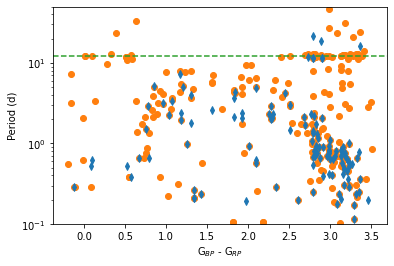

In [48]:
plt.plot(bp_rp,summary_gaia["Prot"],'.',color="grey",alpha=0.5)
plt.plot(bp_rp[clean],summary_gaia["Prot"][clean],'d',ms=5,zorder=5)
plt.plot(bp_rp2[clean2],summary2_gaia["Prot"][clean2],'o')
# plt.plot(bp_rp2[clean2],summary2_gaia["Prot_avg"][clean2],'s',zorder=-2)
print(len(np.where(clean2)[0]))

plt.ylim(0.1,50)
plt.yscale("log")

plt.xlabel(r"G$_{BP}$ - G$_{RP}$")
plt.ylabel("Period (d)")

ax = plt.gca()
ax.axhline(12,linestyle="--",color="C2")

In [49]:
results2.dtype

dtype([('target_name', '<i8'), ('provenance_name', '<U6'), ('sequence_number', '<i8'), ('obs_id', '<U77'), ('productFilename', '<U82'), ('author', '<U6'), ('fund_periods', '<f8'), ('fund_powers', '<f8'), ('sig_periods', '<f8'), ('sig_powers', '<f8'), ('sec_periods', '<f8'), ('sec_powers', '<f8'), ('thresholds', '<f8'), ('tics', '<i8'), ('num_sig_peaks', '<i8'), ('harm_types', '<U10'), ('flux_cols', '<U12'), ('clean60', '<i8'), ('half', '<i8'), ('dbl', '<i8'), ('period_short', '<f8'), ('power_short', '<f8')])

(array([1742.,    0.,    0.,    0.,    0.,  992.,    0.,    0.,    0.,
          62.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

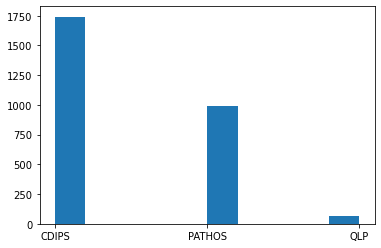

In [50]:
plt.hist(results2["provenance_name"][results2["clean60"]==0])

(0.0, 25.0)

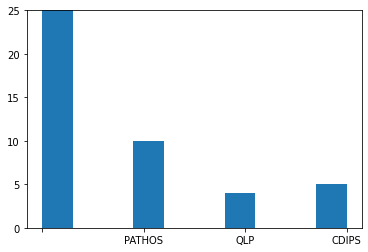

In [51]:
plt.hist(summary2_gaia["provenance_name"][summary2_gaia["Nclean"]>0])
plt.ylim(0,25)

(array([305., 129.,  51., 310., 303., 285., 272., 262., 115., 121., 122.]),
 array([ 0.        ,  0.90909091,  1.81818182,  2.72727273,  3.63636364,
         4.54545455,  5.45454545,  6.36363636,  7.27272727,  8.18181818,
         9.09090909, 10.        ]),
 <BarContainer object of 11 artists>)

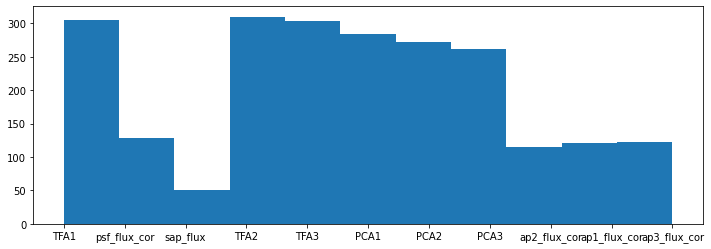

In [65]:
plt.figure(figsize=(12,4))
plt.hist(results2["flux_cols"][(results2["clean60"]==0) & (results2["sig_periods"]<13)],bins=11)

(0.0, 1.0)

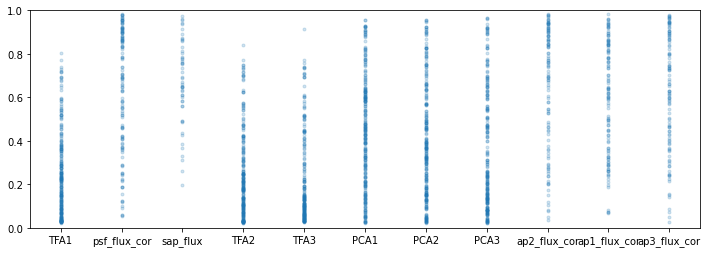

In [57]:
plt.figure(figsize=(12,4))
clean_short = (results2["clean60"]==0) & (results2["sig_periods"]<13)
plt.plot(results2["flux_cols"][clean_short],results2["sig_powers"][clean_short],'.',alpha=0.2)
plt.ylim(0,1)